### Лабораторная работа №1. Основы машинного обучения

In [13]:
import os
import io
import random
import tarfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

tar_path = 'notMNIST_large.tar.gz'
tar_general_dir = 'notMNIST_large'
total_images = 200000 + 10000 + 19000
train_size = 200000 // 10
val_size = 10000 // 10
test_size = 19000 // 10

**Задание 1.** Загрузите данные и отобразите на экране несколько из изображений с помощью языка Python

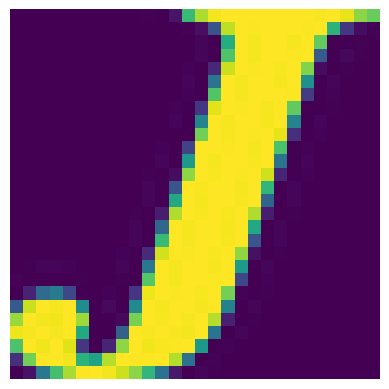

In [2]:
with tarfile.open(tar_path, 'r') as tar:
    image_files = tar.getmembers()
    
    for image_file in image_files[:3]:
        extracted_file = tar.extractfile(image_file)
        if extracted_file:
            image = Image.open(io.BytesIO(extracted_file.read()))
            plt.imshow(image)
            plt.axis('off')
            plt.show()


**Задание 2.** Проверьте, что классы являются сбалансированными, т.е. количество изображений, принадлежащих каждому из классов, примерно одинаково (В данной задаче 10 классов).

Изображения в архиве с выборкой помещены в 10 папок, каждая из которых соответствует своему классу, следовательно, задача сводится к подсчету изображений в каждой из папок

In [3]:
folder_counts = defaultdict(int)
general_size = 0

with tarfile.open(tar_path, 'r:gz') as tar:
    for member in tar.getmembers():
        if member.isfile():
            parts = member.name.split('/')
            if len(parts) > 1 and parts[0] == tar_general_dir:
                folder_name = parts[1]
                if folder_name in 'ABCDEFGHIJ':
                    folder_counts[folder_name] += 1
                
for folder in 'ABCDEFGHIJ':
    print(f'Класс {folder}: {folder_counts[folder]} объектов')
    general_size += folder_counts[folder]
    
print(f'Общее количество: {general_size} объектов')

Класс A: 52912 объектов
Класс B: 52912 объектов
Класс C: 52912 объектов
Класс D: 52912 объектов
Класс E: 52912 объектов
Класс F: 52912 объектов
Класс G: 52912 объектов
Класс H: 52912 объектов
Класс I: 52912 объектов
Класс J: 52911 объектов
Общее количество: 529119 объектов


Как видно, классы действительно являются сбалансированными

**Задание 3** Разделите данные на три подвыборки: обучающую (200 тыс. изображений), валидационную (10 тыс. изображений) и контрольную (тестовую) (19 тыс. изображений)

Загрузим все изображения из архива

In [4]:
with tarfile.open(tar_path, 'r:gz') as tar:
    tar.extractall(path='.')

image_paths = defaultdict(list)

for folder in os.listdir(tar_general_dir):
    folder_path = os.path.join(tar_general_dir, folder)
    if os.path.isdir(folder_path):
        for img_file in os.listdir(folder_path):
            image_paths[folder].append(os.path.join(folder_path, img_file))

Разделим изображения на три выборки

In [5]:
train_list, val_list, test_list = [], [], []
for class_images in image_paths.values():
    random.shuffle(class_images)
    train_list.extend(class_images[:train_size])
    val_list.extend(class_images[train_size:train_size + val_size])
    test_list.extend(class_images[train_size + val_size:train_size + val_size + test_size])

**Задание 4.** Проверьте, что данные из обучающей выборки не пересекаются с данными из валидационной и контрольной выборок.


In [6]:
if set(train_list).isdisjoint(set(val_list + test_list)):
    print("Списки не содержат одинаковых элементов.")
else:
    print("Списки содержат одинаковые элементы.")


Списки не содержат одинаковых элементов.


**Задание 5.** Постройте простейший классификатор (например, с помощью логистической регрессии). Постройте график зависимости точности классификатора от размера обучающей выборки (50, 100, 1000, 50000).


Определим функцию для загрузки данных и создадим маркированные списки 

In [7]:
def load_images(image_list):
    data = []
    labels = []
    for img_path in image_list:
        try:
            img = Image.open(img_path).convert('L')
            #img = img.resize((64, 64))
            img_array = np.array(img).flatten()  # Преобразование изображения в одномерный массив
            data.append(img_array)
            label = os.path.basename(os.path.dirname(img_path))  # Метка класса
            labels.append(label)
        except:
            print("Unprocessable entity")
    return np.array(data), np.array(labels)

train_data, train_labels = load_images(train_list)
val_data, val_labels = load_images(val_list)
test_data, test_labels = load_images(test_list)

Unprocessable entity


Проведем обучение модели (точка останова выставлена на 1500 итерациях)

In [8]:
# Объединение обучающих и валидационных данных для обучения модели
X_train = np.concatenate((train_data, val_data))
y_train = np.concatenate((train_labels, val_labels))

# Создание и обучение модели логистической регрессии
model = LogisticRegression(max_iter=1500)
model.fit(X_train, y_train)

/home/relsa/Документы/projects/machine-learning/LR-1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1500)

Проведем оценку полученной модели. Оценка на тестовом наборе.

In [9]:
y_pred = model.predict(test_data)
accuracy = accuracy_score(test_labels, y_pred)
print(f'Точность модели на тестовом наборе: {accuracy:.2f}')

Точность модели на тестовом наборе: 0.83


Оценка на валидационном наборе

In [10]:
y_val_pred = model.predict(val_data)
val_accuracy = accuracy_score(val_labels, y_val_pred)
print(f'Точность модели на валидационном наборе: {val_accuracy:.2f}')

Точность модели на валидационном наборе: 0.84


Мы получили удовлетворительную точность на тестовых и валидационных данных. Теперь проведем исследования зависимости точности классификатора от размеров выборки.

Определим размеры обучающих выборок

In [45]:
train_sizes = [50, 100, 1000, 5000]
accuracies = []

Обучим модели и получим их точности на разных размерностях

In [46]:
for size in train_sizes:
    X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, train_size=size, random_state=42)
    
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    accuracies.append(accuracy_score(y_test, y_pred))

/home/relsa/Документы/projects/machine-learning/LR-1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Построим график

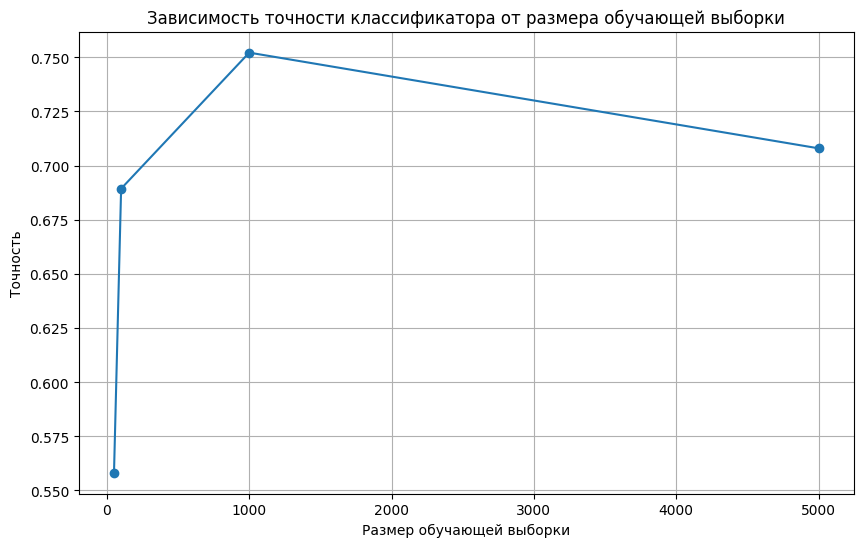

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, accuracies, marker='o')
plt.title('Зависимость точности классификатора от размера обучающей выборки')
plt.xlabel('Размер обучающей выборки')
plt.ylabel('Точность')
plt.grid(True)
plt.show()


Проведем дополнительные исследования. Изменим количество итераций, построим пять графиков на 50, 100, 200, 1000 и 2000 итераций.

In [53]:
accuracies_50 = []
accuracies_100 = []
accuracies_200 = []
accuracies_2000 = []

Обучим модель на 50 итерациях

In [54]:
for size in train_sizes:
    X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, train_size=size, random_state=42)
    
    clf = LogisticRegression(max_iter=50)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    accuracies_50.append(accuracy_score(y_test, y_pred))

/home/relsa/Документы/projects/machine-learning/LR-1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/relsa/Документы/projects/machine-learning/LR-1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

Обучим модель на 100 итерациях

In [55]:
for size in train_sizes:
    X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, train_size=size, random_state=42)
    
    clf = LogisticRegression(max_iter=100)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    accuracies_100.append(accuracy_score(y_test, y_pred))

/home/relsa/Документы/projects/machine-learning/LR-1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Обучим модель на 200 итерациях

In [56]:
for size in train_sizes:
    X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, train_size=size, random_state=42)
    
    clf = LogisticRegression(max_iter=200)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    accuracies_200.append(accuracy_score(y_test, y_pred))

/home/relsa/Документы/projects/machine-learning/LR-1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Обучим модель на 2000 итерациях

In [57]:
for size in train_sizes:
    X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, train_size=size, random_state=42)
    
    clf = LogisticRegression(max_iter=2000)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    accuracies_2000.append(accuracy_score(y_test, y_pred))

/home/relsa/Документы/projects/machine-learning/LR-1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Построим графики

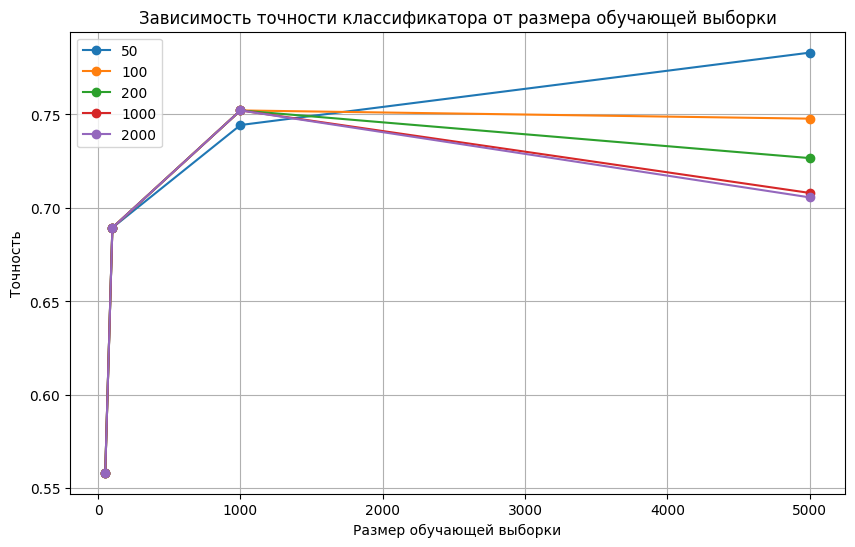

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, accuracies_50, marker='o', label="50")
plt.plot(train_sizes, accuracies_100, marker='o', label="100")
plt.plot(train_sizes, accuracies_200, marker='o', label="200")
plt.plot(train_sizes, accuracies, marker='o', label="1000")
plt.plot(train_sizes, accuracies_2000, marker='o', label="2000")
plt.title('Зависимость точности классификатора от размера обучающей выборки')
plt.xlabel('Размер обучающей выборки')
plt.ylabel('Точность')
plt.grid(True)
plt.legend()
plt.show()

Как видно, отличия в точности заметны уже при выборке размером 1000 объектов, а при выборке размером 5000 эти отличия становятся довольно значительными. Связано это может быть с проблемой переобучения модели (значительное кол-во итераций при малом размере набора данных).